In [1]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import Conv2D,MaxPooling2D,Flatten,Conv1D
from keras.preprocessing import sequence

from sklearn.model_selection import train_test_split


import json
import numpy as np
import pandas as pd
from sklearn import preprocessing
import keras
from keras.layers import Input,Dense,Lambda
from keras.models import Model
import os
import numpy as np
from keras.preprocessing import image as image_p
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg16 import VGG16
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import pickle
import matplotlib.image as mpimg
from keras.preprocessing import image
from  matplotlib import pyplot
from keras.layers.normalization import BatchNormalization
import cv2
import seaborn as sns
import random
from PIL import Image
from sklearn.utils import class_weight
from keras.layers import Reshape
import keras.backend as K
import math
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5629182794806866040, name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11589767406350774761
 physical_device_desc: "device: XLA_GPU device", name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10910108576941122608
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5730009088
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1587004768824983387
 physical_device_desc: "device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [3]:
with open('data-gender0.pckl','rb') as file:
    train_images,train_labels,test_images,test_labels = pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: 'data-gender0.pckl'

In [17]:
class CustomModelCheckpoint(ModelCheckpoint):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            filepath = self.filepath.format(epoch=epoch + 1, **logs)
            if self.save_best_only:
                current = logs.get(self.monitor)
                if current is None:
                    warnings.warn('Can save best model only with %s available, '
                                  'skipping.' % (self.monitor), RuntimeWarning)
                else:
                    if self.monitor_op(current, self.best):
                        if self.verbose > 0:
                            print('\nEpoch %05d: %s improved from %0.5f to %0.5f,'
                                  ' saving model to %s'
                                  % (epoch + 1, self.monitor, self.best,
                                     current, filepath))
                        self.best = current
                        if self.save_weights_only:
                            #self.model.save_weights(filepath, overwrite=True)
                            print("asd")
                            try:
                                with open(filepath,'wb') as f:
                                    pickle.dump(self.model.get_weights(),f)
                            except Exception as ex:
                                print("Could not write",ex)
                        else:
                            self.model.save(filepath, overwrite=True)
                    else:
                        if self.verbose > 0:
                            print('\nEpoch %05d: %s did not improve from %0.5f' %
                                  (epoch + 1, self.monitor, self.best))
            else:
                if self.verbose > 0:
                    print('\nEpoch %05d: saving model to %s' % (epoch + 1, filepath))
                if self.save_weights_only:
                    self.model.save_weights(filepath, overwrite=True)
                else:
                    self.model.save(filepath, overwrite=True)

In [4]:
cnn_base = VGG16(input_shape=(96,96,3),include_top=False,weights='imagenet')

for layer in cnn_base.layers:
    #if layer.name=='block5_conv3':
    #    break
    layer.trainable = False

x = cnn_base.get_layer('block5_pool').output
x = Flatten()(x)
x = Dense(256,activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256,activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1,activation='sigmoid')(x)

model = Model(inputs=cnn_base.input, outputs=x)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
initial_weights = model.get_weights()

58892288/58889256 [==============================] - 4s 0us/step


W0318 05:54:56.500078 140270310000384 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
__________

In [6]:
train_pred = []
test_pred = []

train_scores = []
test_scores = []

history_record = []

for i in range(5):
    print("Loading file")
    #model.save_weights('model.h5')
    with open('data-gender'+str(i)+'.pckl','rb') as file:
        train_images,train_labels,test_images,test_labels = pickle.load(file)
    try:
        with open('gender_classification_vgg16'+str(i)+'.hd5','rb') as f:
            model_weights = pickle.load(f)
            print("loaded model")
    except:
        print("setting initial weights")
        model_weights = initial_weights
    model.set_weights(model_weights)
    train_ls = []
    for l in train_labels:
        if l=='M':
            train_ls.append(1)
        else:
            train_ls.append(0)
    test_ls = []
    for l in test_labels:
        if l=='M':
            test_ls.append(1)
        else:
            test_ls.append(0)
    checkpoint = CustomModelCheckpoint('gender_classification_vgg16'+str(i)+'.hd5', monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True,mode='max')
    callbacks_list = [checkpoint]

    history = model.fit(x=np.array(train_images),y=np.array(train_ls),batch_size=5,epochs=30,
                       validation_data=(np.array(test_images),np.array(test_ls)),callbacks=callbacks_list)
    train_score = model.evaluate(x=np.array(train_images),y=np.array(train_ls),batch_size=50)
    test_score = model.evaluate(x=np.array(test_images),y=np.array(test_ls),batch_size=50)
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    print("predicting")
    print("Test Score",test_score)
    train_predictions = model.predict(x=np.array(train_images),batch_size=50)
    test_predictions = model.predict(x=np.array(test_images),batch_size=50)
    
    train_pred.append(train_predictions)
    test_pred.append(test_predictions)

Loading file


FileNotFoundError: [Errno 2] No such file or directory: 'data-gender0.pckl'

In [21]:
with open('data-gender0.pckl','rb') as file:
    train_images,train_labels,test_images,test_labels = pickle.load(file)

ValueError: too many values to unpack (expected 4)

In [10]:
historys = []
for hist in history_record:
    historys.append(hist.history)
    
if rotated:
    with open('vgg16-predictions-rotated.pckl','wb') as file:
        pickle.dump((train_pred,test_pred,historys,train_scores,test_scores),file)
else:
    with open('vgg16-predictions.pckl','wb') as file:
        pickle.dump((train_pred,test_pred,historys,train_scores,test_scores),file)

In [ ]:
rotated

In [ ]:
with open('vgg16-predictions-rotated.pckl','rb') as vgg16:
    train_pred,test_pred,historys,train_scores,test_scores = pickle.load(vgg16)

NameError: name 'history' is not defined

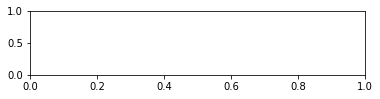

In [8]:
plt.subplot(3,1,1)
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('Total Loss')
plt.show()
plt.subplot(3,1,2)
plt.plot(history.history['localization_output_iou_metric'])
plt.xlabel('epochs')
plt.ylabel('IoU Metric')
plt.show()
plt.subplot(3,1,3)
plt.plot(history.history['classification_output_loss'])
plt.xlabel('epochs')
plt.ylabel('Cross Entropy Loss')
plt.show()

In [7]:
from sklearn import preprocessing
import numpy
le = preprocessing.LabelEncoder()
le.classes_ = numpy.load('classes.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'classes.npy'

In [22]:
idx = np.random.randint(low=0,high=np.array(test_images).shape[0])
bb,classify = model.predict(np.expand_dims(np.array(test_images)[idx],0))
[[xmin,ymin,xmax,ymax]]= bb
img = cv2.rectangle(np.array(test_images)[idx], (xmin,ymin), (xmax,ymax), (0,255,0), 4)
pil_im = Image.fromarray(img)
a = np.argmax(classify,axis=1)[0]
label = le.inverse_transform(np.argmax(classify,axis=1))
#print(label[0])
#y = ymin - 15 if ymin - 15 > 15 else ymin + 15
plt.title("Predicted: "+label[0]+", Actual: "+le.inverse_transform(np.argmax(test_predictions[idx])))
plt.imshow(pil_im)
print(label[0])

/home/parmeet/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


IndexError: list index out of range

In [ ]:
# print(np.mean(np.array(test_cvscores)[:,1]))
# print(np.std(np.array(test_cvscores)[:,1]))

# print(np.mean(np.array(validation_cvscores)[:,1]))
# print(np.std(np.array(validation_cvscores)[:,1]))

In [ ]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = np.array(labels_test)!=predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    imag = normalize_image(im)
    #plt.imshow(imag)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+np.array(labels_test)[i]+', Predicted: '+predicted_labels[i])
plt.show()

In [ ]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = np.array(labels_test)==predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    imag = normalize_image(im)
    #plt.imshow(imag)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+np.array(labels_test)[i]+', Predicted: '+predicted_labels[i])
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_test, predicted_labels,labels=np.unique(labels_))
print(cm)

NameError: name 'labels_test' is not defined

In [ ]:
confusion_matrix(labels_test,predicted_labels)

labels_=list(np.unique(labels_test))
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels_)
ax.set_yticklabels([''] + labels_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [35]:
idx = 101

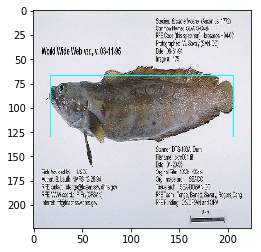

In [36]:
img = test_images[idx]
h,w,cx,cy,angle = testing_bboxes[idx]
rectange_points = [(w/2.0,h/2.0),(w/2.0,-h/2.0),(-w/2.0,-h/2.0),((-w/2.0,h/2.0))]
points = []
#angle = (3.14159265358979323846/2) - angle
for xr,yr in rectange_points:
    xr = math.cos(angle)*xr - math.sin(angle)*yr
    yr = math.sin(angle)*xr + math.cos(angle)*yr

    xr = xr + cx
    yr = yr + cy
    points.append(xr)
    points.append(yr)
pts = np.array(points)
pts = pts.reshape((-1,1,2))
img = cv2.polylines(img,np.int32([pts]),True,(0,255,255))
pil_im = Image.fromarray(img)
plt.imshow(pil_im)

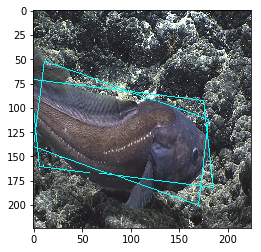

In [28]:
idx = 5
img = test_images[idx]
pts = np.array(test_bboxes[idx])
pts = pts.reshape((-1,1,2))
img = cv2.polylines(img,np.int32([pts]),True,(0,255,255))
pil_im = Image.fromarray(img)
plt.imshow(pil_im)

In [8]:
idx = 22
img = test_images[idx]
[[w,h,cx,cy,angle]] = mod.predict(np.expand_dims(test_images[idx],axis=0))[0]
rectange_points = [(w/2.0,h/2.0),(w/2.0,-h/2.0),(-w/2.0,-h/2.0),((-w/2.0,h/2.0))]
points = []
#angle = (3.14159265358979323846/2) - angle
for xr,yr in rectange_points:
    xr = math.cos(angle)*xr - math.sin(angle)*yr
    yr = math.sin(angle)*xr + math.cos(angle)*yr

    xr = xr + cx
    yr = yr + cy
    points.append(xr)
    points.append(yr)
pts = np.array(points)
pts = pts.reshape((-1,1,2))
img = cv2.polylines(img,np.int32([pts]),True,(0,255,255))
pil_im = Image.fromarray(img)
plt.imshow(pil_im)

NameError: name 'test_images' is not defined

In [57]:
w,h,cx,cy,angle

(0.9990823, 0.00075547496, 4.3644923e-05, 0.00010419192, 1.4448374e-05)

In [53]:
mod.predict(np.expand_dims(test_images[6],axis=0))

[array([[149.92322 ,  82.941605, 126.17159 , 112.74586 ,  -0.889715]],
       dtype=float32),
 array([[1.1669288e-03, 9.3571018e-08, 7.4474216e-02, 3.6341050e-01,
         5.6094831e-01]], dtype=float32)]

In [79]:
test_scores

[]